To install a package over pip so that it works in the notebook you have to run: 
```bash
$ source /opt/tljh/user/bin/activate
$ pip install <package name>
```
and then restart the ipykernal.

Imports

In [1]:
import ferryFile
import port
import numpy as np
import heapq
import scipy
from matplotlib import pyplot as plt 
import matplotlib_inline
import itertools

Constants and Objects

In [2]:
MAX_SIMULATION_TIME = 1000


MEAN_TRIP_TIME = 20
SD_TRIP_TIME = 1.5
MEAN_LOADING_UNLOADING_TIME = 10
SD_LOADING_UNLOADING_TIME = 1


PORT_CODES = ["SWB", "TSA", "SGI", "HSB", "NAN", "LNG"]
FERRIES = []
SEEDS = [234,4234,324,325543,2,34,546,74,567,568,568,89,364575,342,45,3456473,546,3456473]
SEEDS = set(SEEDS)

# Programmatically create the port objects for each of the port codes
for port_code in PORT_CODES:
    globals()[port_code] = port.Port() 
    globals()[port_code].port_code = port_code


To generate the cdf we can use np.norm.cdf(val, loc, scale) where location is the mean and scale is the standard deviation. 
To find the values for a certain percent we can use ppf from scipy stats

In [3]:
def generate_scheduled_departure_and_arrival_times(arrival, departure, trip_length, wanted_on_time_percent: float = 0.85) -> None:
    trip_distribution = scipy.stats.norm(loc=MEAN_TRIP_TIME, scale=SD_TRIP_TIME)
    loading_unloading_distribution = scipy.stats.norm(loc=MEAN_LOADING_UNLOADING_TIME, scale=SD_LOADING_UNLOADING_TIME)

    current_time = 0
    for i in range(1, trip_length):
        # Add the time to get to the next port
        current_time += trip_distribution.ppf(wanted_on_time_percent)

        # Set the expected arrival time
        arrival[i] = current_time

        # Add the time to load and unload at that port
        current_time += loading_unloading_distribution.ppf(wanted_on_time_percent)

        #Set the expected departure time
        departure[i] = current_time

    for i in range(len(arrival)):
        if type(arrival[i]) not in [int, float]:
            arrival[i] = arrival[i].item()
    for i in range(len(departure)):
        if type(departure[i]) not in [int, float]:
            departure[i] = departure[i].item()
    

In [4]:
expected_arrival = [ 0 for i in range(4)]
expected_departure = [0 for i in range(4)]

generate_scheduled_departure_and_arrival_times(expected_arrival, expected_departure, 4, 0.85)

{0.05: [[3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [2, 2], [3, 2]], 0.1: [[3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [2, 1], [2, 2]], 0.15: [[3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [2, 2], [3, 2], [3, 2], [3, 2], [3, 2], [2, 1], [2, 2]], 0.2: [[3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [2, 2], [2, 2], [3, 2], [3, 2], [3, 2], [2, 1], [0, 1]], 0.25: [[3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [2, 2], [3, 2], [3, 2], [2, 2], [2, 1], [3, 2], [3, 2], [3, 2], [2, 1], [0, 0]], 0.3: [[3, 2], [3, 2], [3, 2], [3, 2], [3, 2], [2, 2], [3, 2], [3, 2], [2, 0], [2, 1], [3, 2], [3, 2], [3, 2], [2, 1], [0, 0]], 0.35: [[1, 2], [2, 2], [3, 2], [3, 1], [2, 2], [2, 2], [3, 2], [3, 2], [2, 0], [2, 1], [3, 2], [3, 2], [3, 2], [2, 1], [0, 0]], 0.4: [[1, 1], [1, 2], [3, 2], [3, 1], [1, 1], [1, 2], [3, 2], [3, 2], [2, 0], [2, 1], [3, 2], [3, 1], [3, 

<BarContainer object of 19 artists>

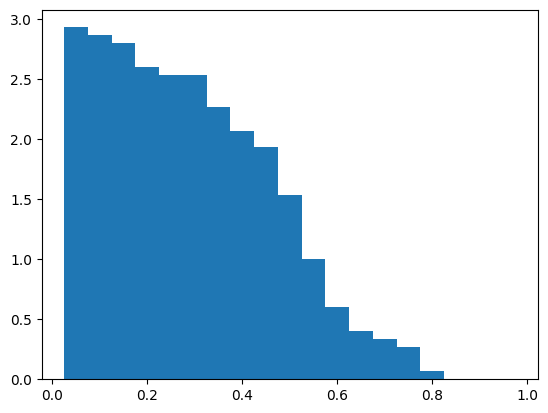

In [5]:


time_to_count_as_late = 0
lates_for_each = {}
for ppf_value in range(5, 100, 5):
    ppf_value = ppf_value / 100
    lates_for_each[ppf_value] = []

    expected_arrival = [ 0 for i in range(4)]
    expected_departure = [0 for i in range(4)]
    generate_scheduled_departure_and_arrival_times(expected_arrival, expected_departure, 4, ppf_value)
    
    for seed_value in SEEDS:
        np.random.seed(seed_value)
        # Most of the trips take the same amount of time independent of the ferry 
        # Makes every port to every other port take 20ish minutes. 
        # Times are made to be the same independent of direction.
        TRIP_TIMES = {}
        for port in PORT_CODES:
            for other_port in [i for i in PORT_CODES if i != port]:
                if other_port + port in TRIP_TIMES.keys():
                    TRIP_TIMES[port+other_port] = TRIP_TIMES[other_port+port]
                else:
                    TRIP_TIMES[port + other_port] = np.random.normal(MEAN_TRIP_TIME, SD_TRIP_TIME)
    
        # Set the loading and unloading times
        # Port + Current_time for every 5 step increment
        LOADING_AND_UNLOADING_TIMES = {}
        for port_code in PORT_CODES:
            for time in range(0, MAX_SIMULATION_TIME, 5):
                LOADING_AND_UNLOADING_TIMES[globals()[port_code] + time] = np.random.normal(MEAN_LOADING_UNLOADING_TIME, SD_LOADING_UNLOADING_TIME)
    
        #Create a ferry object
        QNW = ferryFile.Ferry()
        QNW.ferry_name = "Queen of New Westminster"
        QNW.ferry_code = "QNW"
        QNW.ferry_capacity = 150
        QNW.ferry_route = [TSA, SWB, SGI, TSA]
        QNW.ferry_trip_time = TRIP_TIMES
        QNW.set_expected_departure_times(expected_departure)
        QNW.set_expected_arrival_times(expected_arrival)
        QNW.loading_unloading_time = LOADING_AND_UNLOADING_TIMES
        QNW.trips_required = 1
        
        QNW.trips_completed = 0
        QNW.ferry_current_port_index = 0
        QNW.validate_arrival_and_departure_times()

        QNW.print_stats_at_end = False
    
    
        current_time =0
        event_queue = []
        heapq.heapify(event_queue)
        heapq.heappush(event_queue, (current_time, QNW))
        
    
        current_event = heapq.heappop(event_queue)
        while current_event[1].next_function != None:
            current_time = current_event[0]
    
            next_event_time = current_event[1].next_function(current_time)
            heapq.heappush(event_queue, (next_event_time, current_event[1]))
    
            current_event = heapq.heappop(event_queue)

        lates_for_each[ppf_value].append(QNW.total_times_late(time_to_count_as_late))




print(lates_for_each)
for key in lates_for_each.keys():
    data = lates_for_each[key]
    times_late_to_arrive = [i[0] for i in data]
    times_late_to_depart = [i[1] for i in data]

    times_late_to_arrive = sum(times_late_to_arrive) / len(times_late_to_arrive)
    times_late_to_depart = sum(times_late_to_depart) / len(times_late_to_depart)

    lates_for_each[key] = [times_late_to_arrive, times_late_to_depart]
print(lates_for_each)

plt.bar(lates_for_each.keys(), [lates_for_each[key][0] for key in lates_for_each.keys()], 0.05)